# Mini-CyBERT Training Pipeline
## Complete Training with Comprehensive Evaluation

This notebook implements:
1. Vocabulary Extension
2. Masked Language Modeling (MLM) with validation
3. Named Entity Recognition (NER) Fine-tuning
4. Comprehensive Evaluation with entity-level metrics
5. Visualization and reporting

## 1. Environment Setup and Data Loading

In [ ]:
# Install necessary libraries
!pip install -q transformers datasets evaluate seqeval accelerate scikit-learn matplotlib pandas

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from datasets import Dataset, DatasetDict, load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForMaskedLM,
    AutoModelForTokenClassification,
    DataCollatorForLanguageModeling,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer,
    TrainerCallback
)
from sklearn.feature_extraction.text import TfidfVectorizer
import evaluate
from seqeval.metrics import classification_report, precision_score, recall_score, f1_score

# Mount Google Drive and Set Paths
drive.mount('/content/drive')
CORPUS_PATH = "/content/drive/MyDrive/datasets/cyber/corpus.txt"
NER_CSV_PATH = "/content/drive/MyDrive/datasets/cyber/cyberner_clean.csv"
MODEL_OUTPUT_DIR = "/content/drive/MyDrive/models/mini_cybert_weights"

# Create output directory for results
RESULTS_DIR = f"{MODEL_OUTPUT_DIR}/results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Load raw technical text
with open(CORPUS_PATH, "r") as f:
    lines = [line.strip() for line in f if line.strip()]

print(f"✓ Loaded {len(lines)} samples from corpus.txt")

# Enrich with cybersecurity phrases (man in the middle, SSL, attack types) for MLM
SECURITY_PHRASES_PATH = os.path.join(os.path.dirname(CORPUS_PATH), "security_phrases.txt")
if os.path.exists(SECURITY_PHRASES_PATH):
    with open(SECURITY_PHRASES_PATH, "r", encoding="utf-8") as f:
        extra = [line.strip() for line in f if line.strip() and not line.strip().startswith("#")]
    lines.extend(extra)
    print(f"  + {len(extra)} security phrase lines (man in the middle, SSL, etc.)")
print(f"Total: {len(lines)} samples for MLM")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.5 MB/s eta 0:00:00
Mounted at /content/drive
✓ Loaded 9989 samples from corpus.txt


## 2. Tokenization Comparison (Before Vocabulary Extension)

In [ ]:
# Load base tokenizer for comparison
base_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Sample cybersecurity terms to test
test_terms = [
    "phishing",
    "ransomware",
    "SQL-injection",
    "zero-day",
    "cross-site-scripting",
    "DDoS",
    "malware",
    "firewall",
    "vulnerability",
    "cryptojacking"
]

# Store base tokenization results
base_tokenization = {}
for term in test_terms:
    tokens = base_tokenizer.tokenize(term)
    base_tokenization[term] = {
        'tokens': tokens,
        'count': len(tokens)
    }

print("Base BERT Tokenization:")
for term, data in base_tokenization.items():
    print(f"  {term:25s} -> {data['tokens']} ({data['count']} pieces)")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Base BERT Tokenization:
  phishing                  -> ['phi', '##shing'] (2 pieces)
  ransomware                -> ['ransom', '##ware'] (2 pieces)
  SQL-injection             -> ['sql', '-', 'injection'] (3 pieces)
  zero-day                  -> ['zero', '-', 'day'] (3 pieces)
  cross-site-scripting      -> ['cross', '-', 'site', '-', 'script', '##ing'] (6 pieces)
  DDoS                      -> ['dd', '##os'] (2 pieces)
  malware                   -> ['mal', '##ware'] (2 pieces)
  firewall                  -> ['fire', '##wall'] (2 pieces)
  vulnerability             -> ['vulnerability'] (1 pieces)
  cryptojacking             -> ['crypt', '##oja', '##cking'] (3 pieces)


## 3. Vocabulary Extension (Phase 3)

In [ ]:
model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

# Extract top 5000 cybersecurity terms using TF-IDF
vectorizer = TfidfVectorizer(token_pattern=r"(?u)\b\w[\w-]*\w\b", max_features=5000)
vectorizer.fit(lines)
cyber_vocab = vectorizer.get_feature_names_out()

# Add new tokens to the tokenizer
num_added_toks = tokenizer.add_tokens(list(cyber_vocab))
print(f"✓ Added {num_added_toks} new cybersecurity tokens to the vocabulary.")

# Prepare Masked LM Model and Resize Embeddings
mlm_model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)
mlm_model.resize_token_embeddings(len(tokenizer))
print(f"✓ Model vocabulary size: {len(tokenizer)}")

✓ Added 5000 new cybersecurity tokens to the vocabulary.


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


✓ Model vocabulary size: 32993


## 4. Tokenization Comparison (After Vocabulary Extension)

In [ ]:
# Test extended tokenizer
extended_tokenization = {}
for term in test_terms:
    tokens = tokenizer.tokenize(term)
    extended_tokenization[term] = {
        'tokens': tokens,
        'count': len(tokens)
    }

print("\nExtended Tokenizer Results:")
for term, data in extended_tokenization.items():
    print(f"  {term:25s} -> {data['tokens']} ({data['count']} pieces)")

# Create comparison table
tokenization_comparison = []
for term in test_terms:
    tokenization_comparison.append({
        'Term': term,
        'Base Tokenizer': ' '.join(base_tokenization[term]['tokens']),
        'Base Pieces': base_tokenization[term]['count'],
        'Extended Tokenizer': ' '.join(extended_tokenization[term]['tokens']),
        'Extended Pieces': extended_tokenization[term]['count'],
        'Improvement': base_tokenization[term]['count'] - extended_tokenization[term]['count']
    })

tokenization_df = pd.DataFrame(tokenization_comparison)
print("\n" + "="*80)
print("TOKENIZATION IMPROVEMENT TABLE")
print("="*80)
print(tokenization_df.to_string(index=False))

# Save to CSV
tokenization_df.to_csv(f"{RESULTS_DIR}/tokenization_comparison.csv", index=False)
print(f"\n✓ Saved tokenization comparison to {RESULTS_DIR}/tokenization_comparison.csv")


Extended Tokenizer Results:
  phishing                  -> ['phishing'] (1 pieces)
  ransomware                -> ['r', 'ans', 'om', 'war', 'e'] (5 pieces)
  SQL-injection             -> ['sql', '-', 'injection'] (3 pieces)
  zero-day                  -> ['zero', '-', 'day'] (3 pieces)
  cross-site-scripting      -> ['cross-site', '-', 'scripting'] (3 pieces)
  DDoS                      -> ['ddos'] (1 pieces)
  malware                   -> ['mal', 'war', 'e'] (3 pieces)
  firewall                  -> ['firewall'] (1 pieces)
  vulnerability             -> ['vulnerability'] (1 pieces)
  cryptojacking             -> ['crypt', 'o', '##j', 'ack', 'in', 'g'] (6 pieces)

TOKENIZATION IMPROVEMENT TABLE
                Term              Base Tokenizer  Base Pieces     Extended Tokenizer  Extended Pieces  Improvement
            phishing                 phi ##shing            2               phishing                1            1
          ransomware               ransom ##ware            2    

## 5. Masked Language Modeling with Validation (Phase 4)

In [ ]:
# Split corpus into train/validation (90/10 split)
from sklearn.model_selection import train_test_split

train_lines, val_lines = train_test_split(lines, test_size=0.1, random_state=42)
print(f"Train samples: {len(train_lines)}")
print(f"Validation samples: {len(val_lines)}")

# Tokenize the corpus
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

train_dataset = Dataset.from_dict({"text": train_lines})
val_dataset = Dataset.from_dict({"text": val_lines})

tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_val = val_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

# Callback to track metrics
class MLMMetricsCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.epochs = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and 'loss' in logs:
            self.train_losses.append(logs['loss'])
        if logs and 'eval_loss' in logs:
            self.val_losses.append(logs['eval_loss'])
            self.epochs.append(state.epoch)

mlm_callback = MLMMetricsCallback()

# Training Settings for MLM
mlm_args = TrainingArguments(
    output_dir=f"{MODEL_OUTPUT_DIR}/mlm",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    report_to="none"
)

# Train and Save
mlm_trainer = Trainer(
    model=mlm_model,
    args=mlm_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator=data_collator,
    callbacks=[mlm_callback]
)

print("\nStarting Domain Adaptation (MLM)...")
mlm_trainer.train()

# Save model
mlm_trainer.save_model(f"{MODEL_OUTPUT_DIR}/mlm_final")
tokenizer.save_pretrained(f"{MODEL_OUTPUT_DIR}/mlm_final")
print("✓ MLM model saved")

Train samples: 8990
Validation samples: 999


Map:   0%|          | 0/8990 [00:00<?, ? examples/s]

Map:   0%|          | 0/999 [00:00<?, ? examples/s]


Starting Domain Adaptation (MLM)...


Epoch,Training Loss,Validation Loss
1,2.613300,2.406353
2,2.290300,2.219033
3,2.147900,2.127405


There were missing keys in the checkpoint model loaded: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias'].


✓ MLM model saved


## 6. MLM Evaluation and Perplexity Calculation

In [ ]:
# Get final evaluation metrics
mlm_eval_results = mlm_trainer.evaluate()

# Calculate perplexity
val_perplexity = np.exp(mlm_eval_results['eval_loss'])

# Create MLM results table
mlm_results = pd.DataFrame([
    {
        'Model': 'Mini-CyBERT',
        'Eval Set': 'Validation',
        'MLM Loss': f"{mlm_eval_results['eval_loss']:.4f}",
        'Perplexity': f"{val_perplexity:.2f}"
    }
])

print("\n" + "="*80)
print("MLM PERPLEXITY TABLE")
print("="*80)
print(mlm_results.to_string(index=False))

# Save results
mlm_results.to_csv(f"{RESULTS_DIR}/mlm_results.csv", index=False)
print(f"\n✓ Saved MLM results to {RESULTS_DIR}/mlm_results.csv")


MLM PERPLEXITY TABLE
      Model   Eval Set MLM Loss Perplexity
Mini-CyBERT Validation   2.1655       8.72

✓ Saved MLM results to /content/drive/MyDrive/models/mini_cybert_weights/results/mlm_results.csv


## 7. MLM Training Curves Visualization

✓ Saved training curves to /content/drive/MyDrive/models/mini_cybert_weights/results/mlm_training_curves.png


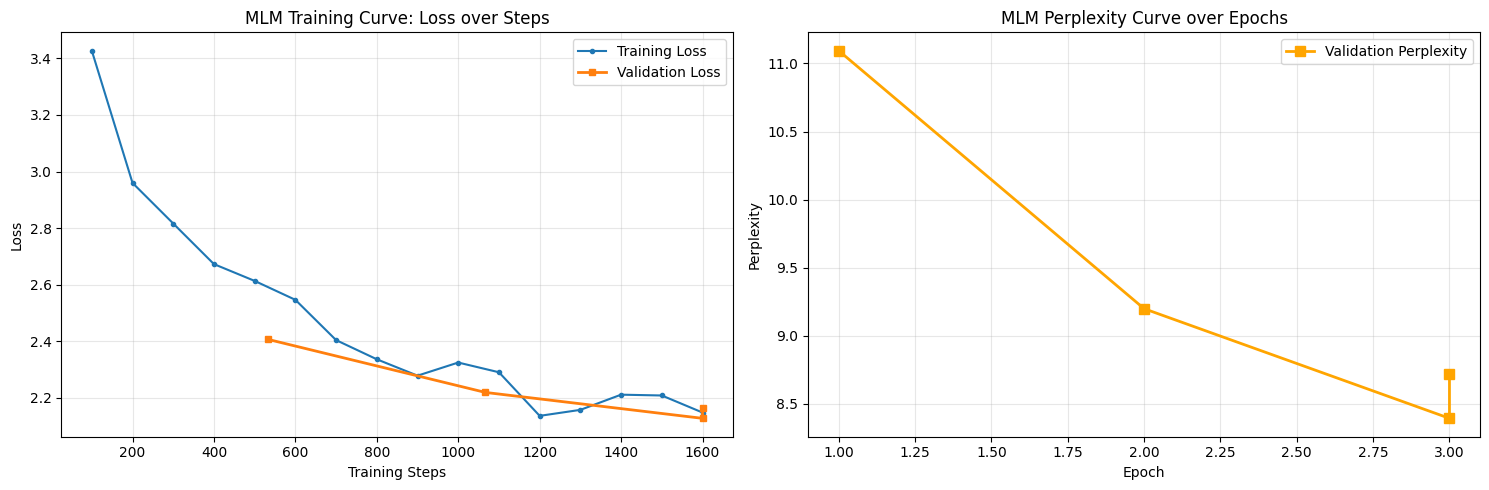

In [ ]:
# Extract training history
train_history = mlm_trainer.state.log_history

# Parse training and validation losses
train_losses = []
val_losses = []
train_steps = []
val_epochs = []

for entry in train_history:
    if 'loss' in entry and 'epoch' in entry:
        train_losses.append(entry['loss'])
        train_steps.append(entry['step'])
    if 'eval_loss' in entry and 'epoch' in entry:
        val_losses.append(entry['eval_loss'])
        val_epochs.append(entry['epoch'])

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Training and Validation Loss
ax1.plot(train_steps, train_losses, label='Training Loss', marker='o', markersize=3)
if val_losses:
    # Map validation losses to steps (approximate)
    steps_per_epoch = max(train_steps) / max(val_epochs) if val_epochs else 1
    val_steps = [epoch * steps_per_epoch for epoch in val_epochs]
    ax1.plot(val_steps, val_losses, label='Validation Loss', marker='s', markersize=5, linewidth=2)
ax1.set_xlabel('Training Steps')
ax1.set_ylabel('Loss')
ax1.set_title('MLM Training Curve: Loss over Steps')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Perplexity Curve
if val_losses:
    val_perplexities = [np.exp(loss) for loss in val_losses]
    ax2.plot(val_epochs, val_perplexities, label='Validation Perplexity', marker='s', markersize=7, linewidth=2, color='orange')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Perplexity')
    ax2.set_title('MLM Perplexity Curve over Epochs')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/mlm_training_curves.png", dpi=300, bbox_inches='tight')
print(f"✓ Saved training curves to {RESULTS_DIR}/mlm_training_curves.png")
plt.show()

## 8. Named Entity Recognition Fine-Tuning

In [ ]:
# Load cyber-only label schema from same folder as CSV (Option A: upload ner_cyber_labels.json to Drive)
SCHEMA_PATH = os.path.join(os.path.dirname(NER_CSV_PATH), "ner_cyber_labels.json")
if not os.path.exists(SCHEMA_PATH):
    SCHEMA_PATH = "config/ner_cyber_labels.json"
if not os.path.exists(SCHEMA_PATH):
    raise FileNotFoundError(
        f"Schema file not found. Option A: upload ner_cyber_labels.json to the SAME folder as your CSV on Drive. "
        f"CSV is at: {NER_CSV_PATH}, so put ner_cyber_labels.json in: {os.path.dirname(NER_CSV_PATH)}"
    )
with open(SCHEMA_PATH, "r", encoding="utf-8") as f:
    schema = json.load(f)
label_list = schema["label_list"]
tag_mapping = schema.get("tag_mapping", {})
label2id = {l: i for i, l in enumerate(label_list)}
id2label = {i: l for i, l in enumerate(label_list)}
print(f"Cyber-only schema: {len(label_list)} labels")

# Load NER dataset (cleaned) and optionally merge attack-type augmentation
df = pd.read_csv(NER_CSV_PATH)
AUGMENT_PATH = os.path.join(os.path.dirname(NER_CSV_PATH), "ner_attack_type_augment.csv")
if os.path.exists(AUGMENT_PATH):
    df_aug = pd.read_csv(AUGMENT_PATH)
    df = pd.concat([df, df_aug], ignore_index=True)
    print(f"  + merged {len(df_aug.groupby('Sentence_ID'))} augmented sentences (man in the middle, etc.)")
df["Word"] = df["Word"].fillna("#")
df["Tag"] = df["Tag"].fillna("O")

# Map all tags to cyber-only schema (unmapped -> O)
def map_tag(t):
    return tag_mapping.get(t, "O")
df["Tag"] = df["Tag"].apply(map_tag)

# Group by sentence
grouped = df.groupby("Sentence_ID").agg({
    "Word": list,
    "Tag": list
}).reset_index()

def convert_tags_to_ids(tags):
    return [label2id.get(t, label2id["O"]) for t in tags]

grouped["ner_tags"] = grouped["Tag"].apply(convert_tags_to_ids)
grouped = grouped.rename(columns={"Word": "tokens"})

# Create dataset splits (80/20 for train/test, then 80/20 of train for train/val)
full_ds = Dataset.from_pandas(grouped[["tokens", "ner_tags"]])
train_test_split = full_ds.train_test_split(test_size=0.2, seed=42)
train_val_split = train_test_split['train'].train_test_split(test_size=0.2, seed=42)

ner_dataset = DatasetDict({
    "train": train_val_split["train"],
    "validation": train_val_split["test"],
    "test": train_test_split["test"]
})

print(f"\nDataset splits:")
print(f"  Train: {len(ner_dataset['train'])} samples")
print(f"  Validation: {len(ner_dataset['validation'])} samples")
print(f"  Test: {len(ner_dataset['test'])} samples")

Unique tags: 75
['B-ACTIVITY', 'B-APT', 'B-ATTACK_MOTIVATION', 'B-ATTACK_PATTERN', 'B-ATTACK_RESOURCE_LEVEL', 'B-ATTACK_SOPHISTICATION_LEVEL', 'B-CAMPAIGN', 'B-COURSE_OF_ACTION', 'B-DOMAIN', 'B-EMAIL', 'B-ENCRYPTION', 'B-EXPLOIT', 'B-FEATURE', 'B-FILE', 'B-HASH', 'B-IDENTITY', 'B-IMPACT', 'B-INDICATOR', 'B-INFRASTRUCTURE', 'B-INTRUSION_SET', 'B-IP', 'B-LOCATION', 'B-MALWARE', 'B-MALWARE_ANALYSIS', 'B-METHOD', 'B-OBSERVED_DATA', 'B-ORG', 'B-PROTOCOL', 'B-PURPOSE', 'B-SECTEAM', 'B-SOFTWARE', 'B-THREAT_ACTOR', 'B-TIME', 'B-TOOL', 'B-URL', 'B-VICTIM_IDENTITY', 'B-VULNERABILITY', 'I-ACTIVITY', 'I-APT', 'I-ATTACK_MOTIVATION', 'I-ATTACK_PATTERN', 'I-ATTACK_RESOURCE_LEVEL', 'I-ATTACK_SOPHISTICATION_LEVEL', 'I-CAMPAIGN', 'I-COURSE_OF_ACTION', 'I-DOMAIN', 'I-EMAIL', 'I-ENCRYPTION', 'I-EXPLOIT', 'I-FEATURE', 'I-FILE', 'I-HASH', 'I-IDENTITY', 'I-IMPACT', 'I-INDICATOR', 'I-INFRASTRUCTURE', 'I-INTRUSION_SET', 'I-IP', 'I-LOCATION', 'I-MALWARE', 'I-MALWARE_ANALYSIS', 'I-METHOD', 'I-OBSERVED_DATA', 'I-

In [ ]:
# Load tokenizer and model from MLM checkpoint
tokenizer = AutoTokenizer.from_pretrained(f"{MODEL_OUTPUT_DIR}/mlm_final", use_fast=True)
model = AutoModelForTokenClassification.from_pretrained(
    f"{MODEL_OUTPUT_DIR}/mlm_final",
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

# Tokenize and align labels
def tokenize_and_align_labels(examples):
    tokenized = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True
    )

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized.word_ids(batch_index=i)
        prev = None
        label_ids = []

        for w in word_ids:
            if w is None:
                label_ids.append(-100)
            elif w != prev:
                label_ids.append(label[w])
            else:
                label_ids.append(-100)
            prev = w

        labels.append(label_ids)

    tokenized["labels"] = labels
    return tokenized

tokenized_ner = ner_dataset.map(tokenize_and_align_labels, batched=True)
print("✓ Dataset tokenized and labels aligned")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at /content/drive/MyDrive/models/mini_cybert_weights/mlm_final and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6426 [00:00<?, ? examples/s]

Map:   0%|          | 0/1607 [00:00<?, ? examples/s]

Map:   0%|          | 0/2009 [00:00<?, ? examples/s]

✓ Dataset tokenized and labels aligned


## 9. NER Metrics Computation (Entity-Level with Macro-F1)

In [ ]:
seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    preds, labels = p
    preds = np.argmax(preds, axis=2)

    # Convert to label strings
    true_preds = [
        [label_list[p] for p, l in zip(pred, lab) if l != -100]
        for pred, lab in zip(preds, labels)
    ]
    true_labels = [
        [label_list[l] for p, l in zip(pred, lab) if l != -100]
        for pred, lab in zip(preds, labels)
    ]

    # Compute entity-level metrics using seqeval
    results = seqeval.compute(predictions=true_preds, references=true_labels)

    # Also compute macro-averaged F1 using seqeval's classification report
    from seqeval.metrics import classification_report
    report = classification_report(true_labels, true_preds, output_dict=True)

    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
        "macro_f1": report.get('macro avg', {}).get('f1-score', 0.0)
    }

print("✓ Metrics computation function defined")

✓ Metrics computation function defined


## 10. NER Training with Validation Tracking

In [ ]:
training_args = TrainingArguments(
    output_dir=f"{MODEL_OUTPUT_DIR}/ner",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_steps=100,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ner["train"],
    eval_dataset=tokenized_ner["validation"],
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics
)

print("\nStarting NER Fine-tuning...")
trainer.train()

# Save final model
trainer.save_model(f"{MODEL_OUTPUT_DIR}/mini_cybert_final")
tokenizer.save_pretrained(f"{MODEL_OUTPUT_DIR}/mini_cybert_final")
print("✓ NER model saved")

/tmp/ipython-input-739791203.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Starting NER Fine-tuning...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy,Macro F1
1,0.638900,0.574113,0.396502,0.398912,0.397704,0.853534,0.199613
2,0.469100,0.440201,0.527805,0.513116,0.520357,0.883521,0.291392
3,0.353400,0.381011,0.548353,0.614310,0.579461,0.893365,0.361389
4,0.274500,0.375973,0.572140,0.661762,0.613696,0.900087,0.402275
5,0.227400,0.347489,0.617066,0.662401,0.638930,0.908565,0.438212
6,0.185000,0.344824,0.625109,0.688100,0.655094,0.912305,0.457515
7,0.147200,0.350213,0.616293,0.712305,0.660830,0.912207,0.469870
8,0.124800,0.350512,0.633064,0.710493,0.669547,0.914679,0.476463
9,0.115600,0.356767,0.632198,0.716464,0.671698,0.915807,0.478858
10,0.103300,0.357744,0.635017,0.717424,0.673710,0.915948,0.482814


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-sco

✓ NER model saved


## 11. Extract Per-Epoch Validation Metrics

In [ ]:
# Extract validation metrics per epoch from training history
train_history = trainer.state.log_history

epoch_metrics = []
for entry in train_history:
    if 'eval_f1' in entry:
        epoch_metrics.append({
            'Epoch': int(entry['epoch']),
            'Val Precision': f"{entry.get('eval_precision', 0):.4f}",
            'Val Recall': f"{entry.get('eval_recall', 0):.4f}",
            'Val F1': f"{entry.get('eval_f1', 0):.4f}",
            'Val Macro-F1': f"{entry.get('eval_macro_f1', 0):.4f}",
            'Val Accuracy': f"{entry.get('eval_accuracy', 0):.4f}"
        })

epoch_df = pd.DataFrame(epoch_metrics)
print("\n" + "="*80)
print("PER-EPOCH VALIDATION METRICS")
print("="*80)
print(epoch_df.to_string(index=False))

epoch_df.to_csv(f"{RESULTS_DIR}/ner_per_epoch_metrics.csv", index=False)
print(f"\n✓ Saved per-epoch metrics to {RESULTS_DIR}/ner_per_epoch_metrics.csv")


PER-EPOCH VALIDATION METRICS
 Epoch Val Precision Val Recall Val F1 Val Macro-F1 Val Accuracy
     1        0.3965     0.3989 0.3977       0.1996       0.8535
     2        0.5278     0.5131 0.5204       0.2914       0.8835
     3        0.5484     0.6143 0.5795       0.3614       0.8934
     4        0.5721     0.6618 0.6137       0.4023       0.9001
     5        0.6171     0.6624 0.6389       0.4382       0.9086
     6        0.6251     0.6881 0.6551       0.4575       0.9123
     7        0.6163     0.7123 0.6608       0.4699       0.9122
     8        0.6331     0.7105 0.6695       0.4765       0.9147
     9        0.6322     0.7165 0.6717       0.4789       0.9158
    10        0.6350     0.7174 0.6737       0.4828       0.9159

✓ Saved per-epoch metrics to /content/drive/MyDrive/models/mini_cybert_weights/results/ner_per_epoch_metrics.csv


## 12. Final Evaluation on Test Set

In [ ]:
# Evaluate on validation set (best checkpoint)
val_results = trainer.evaluate(eval_dataset=tokenized_ner["validation"])

# Evaluate on test set
test_results = trainer.evaluate(eval_dataset=tokenized_ner["test"])

print("\n" + "="*80)
print("VALIDATION SET RESULTS (Best Checkpoint)")
print("="*80)
print(f"  Precision: {val_results['eval_precision']:.4f}")
print(f"  Recall:    {val_results['eval_recall']:.4f}")
print(f"  F1-Score:  {val_results['eval_f1']:.4f}")
print(f"  Macro-F1:  {val_results['eval_macro_f1']:.4f}")
print(f"  Accuracy:  {val_results['eval_accuracy']:.4f}")

print("\n" + "="*80)
print("TEST SET RESULTS")
print("="*80)
print(f"  Precision: {test_results['eval_precision']:.4f}")
print(f"  Recall:    {test_results['eval_recall']:.4f}")
print(f"  F1-Score:  {test_results['eval_f1']:.4f}")
print(f"  Macro-F1:  {test_results['eval_macro_f1']:.4f}")
print(f"  Accuracy:  {test_results['eval_accuracy']:.4f}")

/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



VALIDATION SET RESULTS (Best Checkpoint)
  Precision: 0.6350
  Recall:    0.7174
  F1-Score:  0.6737
  Macro-F1:  0.4828
  Accuracy:  0.9159

TEST SET RESULTS
  Precision: 0.6412
  Recall:    0.7300
  F1-Score:  0.6827
  Macro-F1:  0.4890
  Accuracy:  0.9131


## 13. Main Results Table (Entity-Level Metrics)

In [ ]:
# Create comprehensive results table
main_results = pd.DataFrame([
    {
        'Model': 'Mini-CyBERT NER',
        'Dataset': 'Validation',
        'Precision': f"{val_results['eval_precision']:.4f}",
        'Recall': f"{val_results['eval_recall']:.4f}",
        'F1 (Entity-Level)': f"{val_results['eval_f1']:.4f}",
        'Macro-F1': f"{val_results['eval_macro_f1']:.4f}",
        'Accuracy': f"{val_results['eval_accuracy']:.4f}"
    },
    {
        'Model': 'Mini-CyBERT NER',
        'Dataset': 'Test',
        'Precision': f"{test_results['eval_precision']:.4f}",
        'Recall': f"{test_results['eval_recall']:.4f}",
        'F1 (Entity-Level)': f"{test_results['eval_f1']:.4f}",
        'Macro-F1': f"{test_results['eval_macro_f1']:.4f}",
        'Accuracy': f"{test_results['eval_accuracy']:.4f}"
    }
])

print("\n" + "="*100)
print("MAIN RESULTS TABLE - NER ENTITY-LEVEL METRICS")
print("="*100)
print(main_results.to_string(index=False))
print("="*100)

# Save to CSV
main_results.to_csv(f"{RESULTS_DIR}/main_results_table.csv", index=False)
print(f"\n✓ Saved main results to {RESULTS_DIR}/main_results_table.csv")


MAIN RESULTS TABLE - NER ENTITY-LEVEL METRICS
          Model    Dataset Precision Recall F1 (Entity-Level) Macro-F1 Accuracy
Mini-CyBERT NER Validation    0.6350 0.7174            0.6737   0.4828   0.9159
Mini-CyBERT NER       Test    0.6412 0.7300            0.6827   0.4890   0.9131

✓ Saved main results to /content/drive/MyDrive/models/mini_cybert_weights/results/main_results_table.csv


## 14. Detailed Per-Entity Classification Report

In [ ]:
# Get detailed predictions for test set
predictions, labels, _ = trainer.predict(tokenized_ner["test"])
preds = np.argmax(predictions, axis=2)

# Align predictions and labels
true_predictions = [
    [label_list[p] for (p, l) in zip(pred, lab) if l != -100]
    for pred, lab in zip(preds, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(pred, lab) if l != -100]
    for pred, lab in zip(preds, labels)
]

# Generate detailed classification report
from seqeval.metrics import classification_report
report = classification_report(true_labels, true_predictions, output_dict=True)

# Helper function to convert numpy types to native Python types
def convert_numpy_types(obj):
    if isinstance(obj, dict):
        return {k: convert_numpy_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(elem) for elem in obj]
    elif isinstance(obj, np.int64):
        return int(obj)
    elif isinstance(obj, np.float64):
        return float(obj)
    return obj

# Convert numpy types in the report before saving
report_serializable = convert_numpy_types(report)

# Save detailed report
with open(f"{RESULTS_DIR}/detailed_classification_report.json", 'w') as f:
    json.dump(report_serializable, f, indent=2)

print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORT (Sample - Top 10 Entity Types)")
print("="*80)

# Show top 10 entity types by support
entity_metrics = []
for entity, metrics in report_serializable.items(): # Use the serializable report for display as well
    if entity not in ['accuracy', 'macro avg', 'weighted avg'] and isinstance(metrics, dict):
        entity_metrics.append({
            'Entity': entity,
            'Precision': f"{metrics['precision']:.4f}",
            'Recall': f"{metrics['recall']:.4f}",
            'F1-Score': f"{metrics['f1-score']:.4f}",
            'Support': metrics['support']
        })

entity_df = pd.DataFrame(entity_metrics).sort_values('Support', ascending=False).head(10)
print(entity_df.to_string(index=False))
print(f"\n✓ Full detailed report saved to {RESULTS_DIR}/detailed_classification_report.json")


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



DETAILED CLASSIFICATION REPORT (Sample - Top 10 Entity Types)
   Entity Precision Recall F1-Score  Support
micro avg    0.6412 0.7300   0.6827    12127
      ORG    0.6983 0.8083   0.7493     1575
     TOOL    0.5964 0.6496   0.6219     1410
 LOCATION    0.7748 0.8680   0.8188     1106
  MALWARE    0.6474 0.7306   0.6865     1106
      APT    0.8191 0.8481   0.8333      790
 IDENTITY    0.6289 0.7066   0.6655      777
     TIME    0.7703 0.8483   0.8074      692
     FILE    0.6551 0.6706   0.6628      674
 ACTIVITY    0.6273 0.7358   0.6773      636

✓ Full detailed report saved to /content/drive/MyDrive/models/mini_cybert_weights/results/detailed_classification_report.json


## 15. Summary Report Generation

In [ ]:
# Create comprehensive summary report
summary_report = {
    "model_name": "Mini-CyBERT",
    "tokenization": {
        "base_vocab_size": 30522,
        "extended_vocab_size": len(tokenizer),
        "tokens_added": num_added_toks,
        "average_fragmentation_reduction": tokenization_df['Improvement'].mean()
    },
    "mlm_training": {
        "train_samples": len(train_lines),
        "val_samples": len(val_lines),
        "epochs": 3,
        "final_val_loss": float(mlm_eval_results['eval_loss']),
        "final_perplexity": float(val_perplexity)
    },
    "ner_training": {
        "num_entity_types": len(label_list),
        "train_samples": len(ner_dataset['train']),
        "val_samples": len(ner_dataset['validation']),
        "test_samples": len(ner_dataset['test']),
        "epochs": 10
    },
    "validation_results": {
        "precision": float(val_results['eval_precision']),
        "recall": float(val_results['eval_recall']),
        "f1_entity_level": float(val_results['eval_f1']),
        "macro_f1": float(val_results['eval_macro_f1']),
        "accuracy": float(val_results['eval_accuracy'])
    },
    "test_results": {
        "precision": float(test_results['eval_precision']),
        "recall": float(test_results['eval_recall']),
        "f1_entity_level": float(test_results['eval_f1']),
        "macro_f1": float(test_results['eval_macro_f1']),
        "accuracy": float(test_results['eval_accuracy'])
    }
}

# Save summary report
with open(f"{RESULTS_DIR}/summary_report.json", 'w') as f:
    json.dump(summary_report, f, indent=2)

print("\n" + "="*80)
print("TRAINING SUMMARY")
print("="*80)
print(json.dumps(summary_report, indent=2))
print("\n✓ Summary report saved to", f"{RESULTS_DIR}/summary_report.json")


TRAINING SUMMARY
{
  "model_name": "Mini-CyBERT",
  "tokenization": {
    "base_vocab_size": 30522,
    "extended_vocab_size": 32993,
    "tokens_added": 5000,
    "average_fragmentation_reduction": -0.1
  },
  "mlm_training": {
    "train_samples": 8990,
    "val_samples": 999,
    "epochs": 3,
    "final_val_loss": 2.1654794216156006,
    "final_perplexity": 8.718780887045812
  },
  "ner_training": {
    "num_entity_types": 75,
    "train_samples": 6426,
    "val_samples": 1607,
    "test_samples": 2009,
    "epochs": 10
  },
  "validation_results": {
    "precision": 0.6350165172251062,
    "recall": 0.7174237577308594,
    "f1_entity_level": 0.673709507835578,
    "macro_f1": 0.48281382149851976,
    "accuracy": 0.9159475281873374
  },
  "test_results": {
    "precision": 0.6411500579374276,
    "recall": 0.730023913581265,
    "f1_entity_level": 0.6827067669172933,
    "macro_f1": 0.48899203036471645,
    "accuracy": 0.9131219254795826
  }
}

✓ Summary report saved to /content/dr

## 16. All Results Files Summary

In [ ]:
print("\n" + "="*80)
print("ALL GENERATED RESULTS FILES")
print("="*80)
print(f"\nResults Directory: {RESULTS_DIR}")
print("\nGenerated files:")
print("  1. tokenization_comparison.csv - Tokenization improvement table")
print("  2. mlm_results.csv - MLM perplexity table")
print("  3. mlm_training_curves.png - MLM training/validation loss and perplexity curves")
print("  4. ner_per_epoch_metrics.csv - Per-epoch validation metrics")
print("  5. main_results_table.csv - Main results table (validation + test)")
print("  6. detailed_classification_report.json - Per-entity metrics")
print("  7. summary_report.json - Complete training summary")



ALL GENERATED RESULTS FILES

Results Directory: /content/drive/MyDrive/models/mini_cybert_weights/results

Generated files:
  1. tokenization_comparison.csv - Tokenization improvement table
  2. mlm_results.csv - MLM perplexity table
  3. mlm_training_curves.png - MLM training/validation loss and perplexity curves
  4. ner_per_epoch_metrics.csv - Per-epoch validation metrics
  5. main_results_table.csv - Main results table (validation + test)
  6. detailed_classification_report.json - Per-entity metrics
  7. summary_report.json - Complete training summary


## 17. Testing the Fine-tuned Mini-CyBERT Model

This section demonstrates how to use the trained Masked Language Modeling (MLM) and Named Entity Recognition (NER) models for inference.

### 17.1 Test Masked Language Modeling (MLM)

In [ ]:
from transformers import pipeline

# Load the tokenizer and MLM model from the saved checkpoint
mlm_tokenizer_path = f"{MODEL_OUTPUT_DIR}/mlm_final"
mlm_model_path = f"{MODEL_OUTPUT_DIR}/mlm_final"

mlm_unmasker = pipeline("fill-mask", model=mlm_model_path, tokenizer=mlm_tokenizer_path)

print(f"✓ Loaded MLM model and tokenizer from {mlm_model_path}")

# Test with a sample cybersecurity sentence with a mask token
mlm_test_sentence = "A phishing email redirected users to a [MASK] website."

print(f"\nTesting MLM with sentence: '{mlm_test_sentence}'")
predictions = mlm_unmasker(mlm_test_sentence)

print("Top 5 MLM predictions:")
for p in predictions:
    print(f"{p['token_str']}")


Device set to use cuda:0


✓ Loaded MLM model and tokenizer from /content/drive/MyDrive/models/mini_cybert_weights/mlm_final

Testing MLM with sentence: 'A phishing email redirected users to a [MASK] website.'
Top 5 MLM predictions:
malicious
remote
local
web
temporary


### 17.2 Test Named Entity Recognition (NER)

In [4]:
def predict_entities(text, threshold=0.2):
    inputs = tokenizer(
        text,
        return_offsets_mapping=True,
        return_tensors="pt",
        truncation=True
    )

    offsets = inputs.pop("offset_mapping")[0].tolist()
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits[0]
    probs = torch.softmax(logits, dim=-1)
    scores, pred_ids = torch.max(probs, dim=-1)

    entities = []
    current = None

    for token, pred_id, score, (start, end) in zip(tokens, pred_ids, scores, offsets):
        if start == end:
            continue

        label = model.config.id2label[pred_id.item()]

        if label == "O" or score.item() < threshold:
            if current:
                entities.append(current)
                current = None
            continue

        label_type = label[2:]

        if label.startswith("B-"):
            if current:
                entities.append(current)
            current = {
                "text": token.replace("##", ""),
                "label": label_type,
                "score": score.item()
            }

        elif label.startswith("I-") and current and current["label"] == label_type:
            if token.startswith("##"):
                current["text"] += token.replace("##", "")
            else:
                current["text"] += " " + token
            current["score"] = max(current["score"], score.item())

        else:
            if current:
                entities.append(current)
            current = None

    if current:
        entities.append(current)

    return entities
